### Load libs

In [1]:
import time
import numpy as np
import matplotlib.pylab as plt
from ridgeplot import ridgeplot
from scipy.stats import norm
import pandas as pd
import random
import os

import torch
import torch
from torch.utils.data import Dataset, DataLoader

from gluformer.attention import *
from gluformer.encoder import *
from gluformer.decoder import *
from gluformer.embed import *
from gluformer.model import *
from utils.train import *


In [2]:
# define save path
save_path = './trials/trial_exp'
if not os.path.exists(save_path):
    os.makedirs(save_path)
# define cache path
cache_path = 'cache/visualize_experiment'
if not os.path.exists(cache_path):
    os.makedirs(cache_path)


### Create data generator

In [3]:
# generate mean with multi-modal behavior
random.seed(0)
def generate_mean(off, modes, lens, betas):
    mean = np.zeros(sum(lens))
    mean[:lens[0]] = off + \
                    np.sin((2*np.pi / 3) * np.arange(0, lens[0], 1)) * betas[0, 0] + \
                    np.cos((2*np.pi / 7) * np.arange(0, lens[0], 1)) * betas[0, 1]
    state = random.randint(0, 1)
    mean[lens[0]:sum(lens)] = off + modes[state] + \
                            np.sin((2*np.pi / 3) * np.arange(lens[0], sum(lens), 1)) * betas[1+state, 0] + \
                            np.cos((2*np.pi / 7) * np.arange(lens[0], sum(lens), 1)) * betas[1+state, 1]
    
    return mean

In [4]:
# generate the covariance matrix and sample from the Gaussian distribution \
# with specified mean and covariance
lens = [5, 9]
modes = [-10, 10]
off = 0
betas = np.array([[0.5, 0.5], [0.3, 0.7], [0.7, 0.3]])

cov = np.zeros((sum(lens), sum(lens)))
row = np.array([1] + [1 / abs(i) for i in range(1, sum(lens))])
for i in range(sum(lens)):
    cov[i, :(i+1)] = np.flip(row[:(i+1)])
    cov[i, (i+1):] = row[1:(sum(lens)-i)]
np.fill_diagonal(cov, 2)

train_samples = 2000
val_samples = 100

train_data = []
val_data = []
test_data = []
for i in range(train_samples):
    if i < val_samples:
        val_data.append([0,
                        np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)), 
                        np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])
        test_data.append([0,
                        np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)), 
                        np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])

    train_data.append([0,
                    np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)), 
                    np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])

In [5]:
# scale the data to [0, 1] using the min and max of the training data
maxx = np.max([train_data[i][1].max() for i in range(len(train_data))])
minn = np.min([train_data[i][1].min() for i in range(len(train_data))])

train_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in train_data]

val_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in val_data]


test_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in test_data]

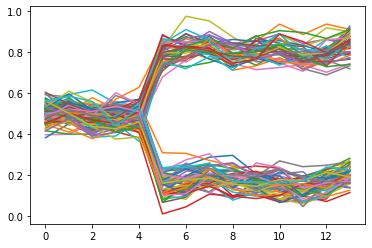

In [6]:
# plot test samples
plot_test = np.vstack([data[1].reshape((1, -1)) for data in test_data])
out = plt.plot(plot_test.transpose())
plt.show()
# save full data
np.save(f"{cache_path}/test_data.npy", plot_test)

### Create PyTorch data set

In [7]:
class Data(Dataset):
  def __init__(self, data, flag='train', size=None):
    # size [seq_len, label_len, pred_len]
    # info
    self.seq_len = size[0]
    self.label_len = size[1]
    self.pred_len = size[2]
    
    # init
    self.data = data
    len_segs = np.array([len(subj_seg[1]) for subj_seg in self.data])
    len_segs = len_segs - self.seq_len - self.pred_len + 1
    self.len_segs = np.insert(np.cumsum(len_segs), 0, 0)
  
  def __getitem__(self, index):

    idx_seg = np.argmax(self.len_segs > index) - 1
    seg = self.data[idx_seg]

    s_begin = index - self.len_segs[idx_seg]
    s_end = s_begin + self.seq_len
    r_begin = s_end - self.label_len
    r_end = r_begin + self.label_len + self.pred_len

    subj_id = seg[0]
    seq_x = seg[1][s_begin:s_end]
    seq_y = seg[1][r_begin:r_end]
    seq_x_mark = seg[2][s_begin:s_end]
    seq_y_mark = seg[2][r_begin:r_end]

    return subj_id, seq_x, seq_y, seq_x_mark, seq_y_mark
  
  def __len__(self):
    return self.len_segs[-1]

In [8]:
len_seq, len_label, len_pred = 4, 2, 2

train_data = Data(train_data, size=[len_seq, len_label, len_pred])
val_data = Data(val_data, size=[len_seq, len_label, len_pred])
test_data = Data(test_data, size=[len_seq, len_label, len_pred])

### Define model

In [9]:
device = torch.device('cuda:0')
model = Gluformer(d_model=256, 
                    n_heads=4, 
                    d_fcn=1024, 
                    r_drop=0.4, 
                    activ="relu", 
                    num_enc_layers=2, 
                    num_dec_layers=1,
                    distil=True,
                    len_seq=len_seq, 
                    len_pred=len_pred,
                    num_features=1)
model.train()
model = model.to(device)

### Train with the infinite mixture objective

In [10]:
model_path = os.path.join(save_path, "model_inf_mixture.pth")
num_samples = 5 # number of samples for MC estimate
batch_size = 256 # batch size for optimization
collate_fn_custom = modify_collate(num_samples)

train_data_loader = DataLoader(train_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

val_data_loader = DataLoader(val_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

test_data_loader = DataLoader(test_data, 
                                batch_size=batch_size, 
                                shuffle=False, 
                                num_workers=0, 
                                drop_last=True,
                                collate_fn = collate_fn_custom)


In [11]:
epochs = 100
criterion =  ExpLikeliLoss(num_samples)
model_optim = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0, 0.9))

# define params for training
TRAIN_STEPS = len(train_data_loader)
early_stop = EarlyStop(5, 1e-6)

for epoch in range(epochs):
    iter_count = 0
    train_loss = []
    
    epoch_time = time.time()
    curr_time = time.time()
    
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
        iter_count += 1
        # zero-out grad
        model_optim.zero_grad()
        pred, true, logvar = process_batch(subj_id=subj_id,
                                            batch_x=batch_x, 
                                            batch_y=batch_y, 
                                            batch_x_mark=batch_x_mark, 
                                            batch_y_mark=batch_y_mark, 
                                            len_pred=len_pred, 
                                            len_label=len_label, 
                                            model=model, 
                                            device=device)
        loss = criterion(pred, true, logvar)
        train_loss.append(float(loss.item()))
        
        # print every 10
        if (i+1) % 10==0:
            print("\t iters: {0} / {3}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item(), TRAIN_STEPS))
            logvar = logvar.reshape(-1, num_samples)
            print(f"\t variance shape: {logvar.shape}")
            print("\t variance: ", np.exp(logvar.detach().cpu().numpy()[0, :]))
            speed = (time.time() - curr_time) / iter_count
            left_time = speed * ((epochs - epoch) * TRAIN_STEPS - i)
            print('\t speed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            curr_time = time.time()
        
        loss.backward()
        model_optim.step()
    # compute average train loss
    train_loss = np.average(train_loss)

    # compute validation loss
    with torch.no_grad():
        val_loss = []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id, 
                                    batch_x=batch_x, 
                                    batch_y=batch_y, 
                                    batch_x_mark=batch_x_mark, 
                                    batch_y_mark=batch_y_mark, 
                                    len_pred=len_pred, 
                                    len_label=len_label, 
                                    model=model, 
                                    device=device)
            loss = criterion(pred, true, logvar)
            val_loss.append(float(loss.item()))
        val_loss = np.average(val_loss)
    
    # check early stopping
    early_stop(val_loss, model, model_path)
    if early_stop.stop:
        print("Early stopping...")
        break

    # update lr
    # adjust_learning_rate(model_optim, epoch, lr)
    
    print("Epoch: {0} Time: {1} Steps: {2}".format(epoch+1, time.time() - epoch_time, TRAIN_STEPS))
    print("Train Loss: {0:.7f} | Val Loss: {1:.7f}".format(train_loss, val_loss))

	 iters: 10 / 70, epoch: 1 | loss: -2.0074182
	 variance shape: torch.Size([256, 5])
	 variance:  [0.01744369 0.01744369 0.01744369 0.01744369 0.00925535]
	 speed: 0.0527s/iter; left time: 368.7297s
	 iters: 20 / 70, epoch: 1 | loss: -2.5308926
	 variance shape: torch.Size([256, 5])
	 variance:  [0.01765103 0.01765103 0.01808007 0.01765103 0.01765103]
	 speed: 0.0372s/iter; left time: 259.8292s
	 iters: 30 / 70, epoch: 1 | loss: -2.6873846
	 variance shape: torch.Size([256, 5])
	 variance:  [0.01769273 0.01769273 0.03149808 0.01769273 0.01858439]
	 speed: 0.0373s/iter; left time: 260.1578s
	 iters: 40 / 70, epoch: 1 | loss: 1.5764654
	 variance shape: torch.Size([256, 5])
	 variance:  [0.01778339 0.12285647 0.01778339 0.01914752 0.01778339]
	 speed: 0.0375s/iter; left time: 260.8599s
	 iters: 50 / 70, epoch: 1 | loss: -3.2432208
	 variance shape: torch.Size([256, 5])
	 variance:  [0.01790969 0.00285019 0.01579691 0.04857698 0.0168234 ]
	 speed: 0.0376s/iter; left time: 261.1893s
	 iter

### Test infinite mixture model

In [12]:
model.train()
calibration = [[] for i in range(len_pred)]
ape, rmse = [], []
with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id, 
                                batch_x=batch_x, 
                                batch_y=batch_y, 
                                batch_x_mark=batch_x_mark, 
                                batch_y_mark=batch_y_mark, 
                                len_pred=len_pred, 
                                len_label=len_label, 
                                model=model, 
                                device=device)
        
        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy(); logvar = logvar.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        logvar = logvar.transpose((1,0,2)).reshape((logvar.shape[1], -1, num_samples)).transpose((1, 0, 2))
        
        # calculate calibration
        for k in range(batch_size):
            for i in range(len_pred):
                ps = [norm.cdf(true[k, i, 0], pred[k, i, j], np.sqrt(np.exp(logvar[k, 0, j]))) 
                        for j in range(num_samples)]
                p = np.average(ps)
                calibration[i].append(p)

        # for metrics: take mean of smaples, take one sample of true
        pred = np.mean(pred, axis=2)
        true = true[:, :, 0]
        # compute APE / RMSE
        ape.append(np.mean(np.abs(true - pred) / true))
        rmse.append(np.sqrt(np.mean((true - pred)**2)))
 
rmse = np.median(rmse)
ape = np.median(ape)
print("APE: {0:.7f}".format(ape))
print("RMSE: {0:.7f}".format(rmse))

APE: 0.4753933
RMSE: 0.1585083


In [13]:
# save for plotting
num_samples=100 # increase number of samples from posterior
collate_fn_custom = modify_collate(num_samples)
test_data_loader = DataLoader(test_data, 
                                batch_size=batch_size, 
                                shuffle=False, 
                                num_workers=0, 
                                drop_last=True,
                                collate_fn = collate_fn_custom)

with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id, 
                                batch_x=batch_x, 
                                batch_y=batch_y, 
                                batch_x_mark=batch_x_mark, 
                                batch_y_mark=batch_y_mark, 
                                len_pred=len_pred, 
                                len_label=len_label, 
                                model=model, 
                                device=device)
        
        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy()
        batch_x = batch_x.detach().cpu().numpy(); logvar = logvar.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        logvar = logvar.transpose((1,0,2)).reshape((logvar.shape[1], -1, num_samples)).transpose((1, 0, 2))
        batch_x = batch_x.transpose((1,0,2)).reshape((batch_x.shape[1], -1, num_samples)).transpose((1, 0, 2))
        break
# save
np.save(f"{cache_path}/pred_mean_infmixt.npy", pred)
np.save(f"{cache_path}/true_mean_infmixt.npy", true)
np.save(f"{cache_path}/pred_logvar_infmixt.npy", logvar)
np.save(f"{cache_path}/input_infmixt.npy", batch_x)

### Train with the MSE

In [14]:
model_path = os.path.join(save_path, "model_norm.pth")
num_samples = 1 
batch_size = 256 # batch size for optimization
collate_fn_custom = modify_collate(num_samples)

train_data_loader = DataLoader(train_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

val_data_loader = DataLoader(val_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

test_data_loader = DataLoader(test_data, 
                                batch_size=batch_size, 
                                shuffle=False, 
                                num_workers=0, 
                                drop_last=True,
                                collate_fn = collate_fn_custom)


In [15]:
epochs = 100
criterion = nn.MSELoss()
model_optim = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0, 0.9))

# define params for training
TRAIN_STEPS = len(train_data_loader)
early_stop = EarlyStop(5, 1e-6)

for epoch in range(epochs):
    iter_count = 0
    train_loss = []
    
    epoch_time = time.time()
    curr_time = time.time()
    
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
        iter_count += 1
        # zero-out grad
        model_optim.zero_grad()
        pred, true, logvar = process_batch(subj_id=subj_id,
                                            batch_x=batch_x, 
                                            batch_y=batch_y, 
                                            batch_x_mark=batch_x_mark, 
                                            batch_y_mark=batch_y_mark, 
                                            len_pred=len_pred, 
                                            len_label=len_label, 
                                            model=model, 
                                            device=device)
        loss = criterion(pred, true)
        train_loss.append(float(loss.item()))
        
        # print every 10
        if (i+1) % 10==0:
            print("\t iters: {0} / {3}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item(), TRAIN_STEPS))
            speed = (time.time() - curr_time) / iter_count
            left_time = speed * ((epochs - epoch) * TRAIN_STEPS - i)
            print('\t speed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            curr_time = time.time()
        
        loss.backward()
        model_optim.step()
    # compute average train loss
    train_loss = np.average(train_loss)

    # compute validation / test loss + test metric
    with torch.no_grad():
        val_loss = []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id, 
                                    batch_x=batch_x, 
                                    batch_y=batch_y, 
                                    batch_x_mark=batch_x_mark, 
                                    batch_y_mark=batch_y_mark, 
                                    len_pred=len_pred, 
                                    len_label=len_label, 
                                    model=model, 
                                    device=device)
            loss = criterion(pred, true)
            val_loss.append(float(loss.item()))
        val_loss = np.average(val_loss)
    
    # check early stopping
    early_stop(val_loss, model, model_path)
    if early_stop.stop:
        print("Early stopping...")
        break

    # update lr
    # adjust_learning_rate(model_optim, epoch, lr)
    
    print("Epoch: {0} Time: {1} Steps: {2}".format(epoch+1, time.time() - epoch_time, TRAIN_STEPS))
    print("Train Loss: {0:.7f} | Val Loss: {1:.7f}".format(train_loss, val_loss))

	 iters: 10 / 70, epoch: 1 | loss: 0.0295530
	 speed: 0.0224s/iter; left time: 156.4235s
	 iters: 20 / 70, epoch: 1 | loss: 0.0315449
	 speed: 0.0228s/iter; left time: 159.4484s
	 iters: 30 / 70, epoch: 1 | loss: 0.0288268
	 speed: 0.0226s/iter; left time: 157.8837s
	 iters: 40 / 70, epoch: 1 | loss: 0.0275139
	 speed: 0.0228s/iter; left time: 158.6279s
	 iters: 50 / 70, epoch: 1 | loss: 0.0277604
	 speed: 0.0240s/iter; left time: 167.0975s
	 iters: 60 / 70, epoch: 1 | loss: 0.0244156
	 speed: 0.0232s/iter; left time: 161.0172s
	 iters: 70 / 70, epoch: 1 | loss: 0.0250849
	 speed: 0.0230s/iter; left time: 159.1222s
Validation loss descreased: inf -> 0.022559037432074547
Epoch: 1 Time: 1.693960189819336 Steps: 70
Train Loss: 0.0271486 | Val Loss: 0.0225590
	 iters: 10 / 70, epoch: 2 | loss: 0.0268635
	 speed: 0.0220s/iter; left time: 152.3059s
	 iters: 20 / 70, epoch: 2 | loss: 0.0230702
	 speed: 0.0229s/iter; left time: 158.6034s
	 iters: 30 / 70, epoch: 2 | loss: 0.0219934
	 speed: 0.

## Test normal model

In [16]:
model.eval()
ape, rmse, likelihood = [], [], []
with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id, 
                                batch_x=batch_x, 
                                batch_y=batch_y, 
                                batch_x_mark=batch_x_mark, 
                                batch_y_mark=batch_y_mark, 
                                len_pred=len_pred, 
                                len_label=len_label, 
                                model=model, 
                                device=device)
        
        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy(); logvar = logvar.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        # for metrics: take mean of smaples, take one sample of true
        pred = np.mean(pred, axis=2)
        true = true[:, :, 0]
        # compute APE / RMSE
        ape.append(np.mean(np.abs(true - pred) / true))
        rmse.append(np.sqrt(np.mean((true - pred)**2)))
        # compute likelihood for computing var later
        likelihood.append(np.mean((pred - true)**2, axis=1))

varhat = np.mean(np.concatenate(likelihood, axis=0))
rmse = np.median(rmse)
ape = np.median(ape)
print("APE: {0:.7f}".format(ape))
print("RMSE: {0:.7f}".format(rmse))

APE: 0.6234942
RMSE: 0.1615020


In [17]:
# save for plotting
with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id, 
                                batch_x=batch_x, 
                                batch_y=batch_y, 
                                batch_x_mark=batch_x_mark, 
                                batch_y_mark=batch_y_mark, 
                                len_pred=len_pred, 
                                len_label=len_label, 
                                model=model, 
                                device=device)
        
        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy(); batch_x = batch_x.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        batch_x = batch_x.transpose((1,0,2)).reshape((batch_x.shape[1], -1, num_samples)).transpose((1, 0, 2))
        break
# save
np.save(f"{cache_path}/pred_mean_norm.npy", pred)
np.save(f"{cache_path}/true_mean_norm.npy", true)
np.save(f"{cache_path}/pred_var_norm.npy", np.array([varhat]))
np.save(f"{cache_path}/input_norm.npy", batch_x)